Projet de Classification Amazon Commerce :http://archive.ics.uci.edu/ml/datasets/Amazon+Commerce+reviews+set

L objectif est de réaliser une classification automatique sur différents types de style 
d’écriture afin de catégoriser un individu selon son style d’écriture. L’ensemble de données est un jeu de données
constitué de 10000 variables quantitatives,1500 individus et d une variable qualitative composée de 50 modalités pour déterminer 
à quelle classe appartient un individu.

In [ ]:
%run loadData

In [ ]:
%run preparationData

In [ ]:
%run featuresSelect

In [ ]:
%run dataAnalysis

In [ ]:
%run vAssembler

In [ ]:
%run cluster

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql import types as types
from pyspark.ml.clustering import KMeans,BisectingKMeans,GaussianMixture
import numpy as np
import math as mt
from sklearn.utils import shuffle

#from loadData import loadData
#from preparationData import preparationData
#from featuresSelect import featuresSelect
#from dataAnalysis import dataAnalysis
#from vAssembler import vAssembler
#from cluster import cluster

# Initialisation de Spark, création du schéma des données et leurs téléchargements
spark = SparkSession.builder.master("local[*]").appName("ProjectRCP216").getOrCreate()


fields = [types.StructField("var"+str(i), types.DoubleType(),True) for i in range(0,10000)]

schema = types.StructType(fields).add("label",types.StringType(),True)


loadDF = loadData()
loadDF.realData(spark,schema,fn)


In [ ]:
loadDF.df.toPandas().head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var9961,var9962,var9963,var9964,var9965,var9966,var9967,var9968,var9969,var9970,var9971,var9972,var9973,var9974,var9975,var9976,var9977,var9978,var9979,var9980,var9981,var9982,var9983,var9984,var9985,var9986,var9987,var9988,var9989,var9990,var9991,var9992,var9993,var9994,var9995,var9996,var9997,var9998,var9999,label
0,5.0,3.0,4.0,4.0,1.0,5.0,1.0,3.0,2.0,4.0,4.0,4.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,Agresti
1,12.0,3.0,6.0,2.0,3.0,4.0,2.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,Agresti
2,3.0,2.0,2.0,4.0,4.0,2.0,2.0,2.0,3.0,1.0,5.0,1.0,0.0,3.0,4.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,Agresti
3,18.0,4.0,6.0,5.0,4.0,2.0,1.0,0.0,4.0,3.0,2.0,1.0,2.0,6.0,2.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Agresti
4,13.0,4.0,7.0,5.0,4.0,5.0,0.0,1.0,0.0,4.0,1.0,3.0,3.0,0.0,4.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,Agresti


In [ ]:
#Obtention de données sous de forme de Dataframe puis nettoyage de données
prepareDF = preparationData(loadDF.getDF(),fn)
prepareDF.dropDuplicates()
prepareDF.dropMissing()
prepareDF.dataShape()


(1480, 10001)


In [ ]:
#Recupération de la dataframe netoyée pour l'analyse de donnée
analysis = dataAnalysis(plt,prepareDF.getDF())

In [ ]:
# Description de données
stats=analysis.statsDescriptive()

In [ ]:
stats.toPandas().head()

In [ ]:
#Calcul des variances
analysis.computeVariance()

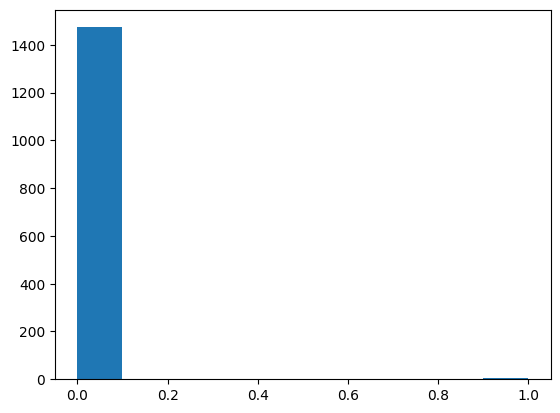

In [ ]:
#Le nombre de variable étant très élévé (10000) On choisi de calculer l'histogramme des varables de variance Min et de Max,  
analysis.histoFunc(analysis.getColVariance(analysis.minVariance()))

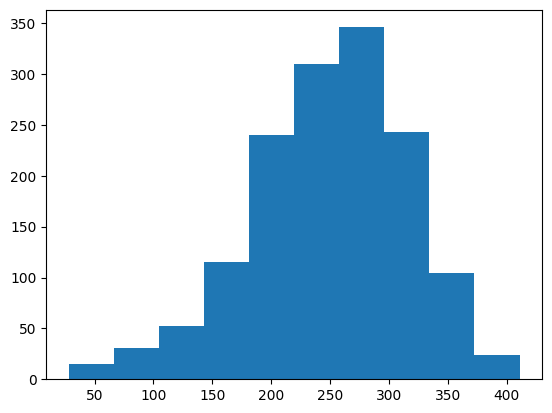

In [ ]:
#Le nombre de variable étant très (10000) On choisi de calculer l'histogramme des varables de variance Min et de Max,  
analysis.histoFunc(analysis.getColVariance(analysis.maxVariance()))

In [ ]:
#Renvoie le nombre de variables corrélées
analysis.ListCorrelationVariables()

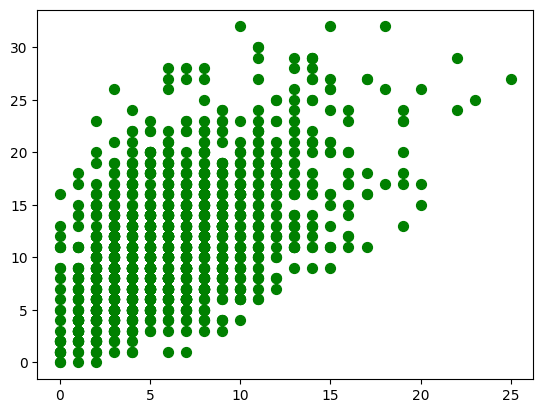

In [ ]:
#illustration de deux variables corrélées
analysis.scatterFunc('var3','var0')

In [ ]:
#Le nombre colonne etant très élévé on est dans un cas de malédiction, on choisi une variable corrélée entre deux variables qui ont les mêmes tendances
#pour reduire le nombre de variable 
analysis.removeCorreled()

In [ ]:
#Obtiention des nouvelles variables après reduction par corrélation et puis élimination des doublons
prepareDF = preparationData(analysis.getDF(),fn)
prepareDF.dropDuplicates()
prepareDF.dropMissing()
prepareDF.dataShape()

(1479, 6022)


In [ ]:
#Transformation des données en vecteur et normalistaion
vect = vAssembler(prepareDF.getDF())
vect.vectStringIndex()
vect.vectAssembler()
vect.scalerStandard()

In [ ]:
# illustration des données obtenues
dataplot = dataAnalysis(plt,vect.getDF())


In [ ]:
p=dataplot.vizData2D(fn)

<Axes: xlabel='x[0]', ylabel='x[1]'>

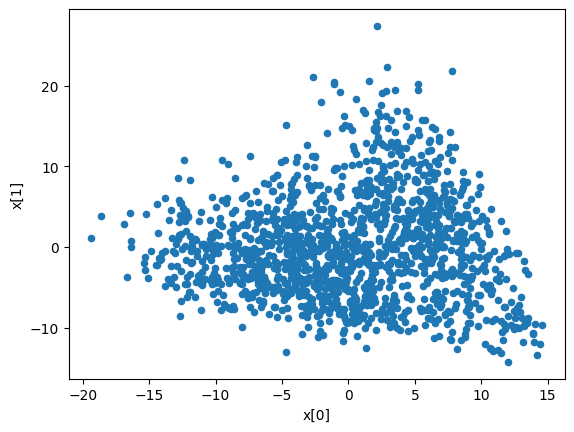

In [ ]:
p.toPandas().plot.scatter('x[0]','x[1]')

In [ ]:
#le nombre de données étant toujours elévé, on selectionne les features importances par random forest 
feature = featuresSelect(dataplot.getDF(),pd,plt)
feature.ModelByRandomForest()
feature.TreeSelect()

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

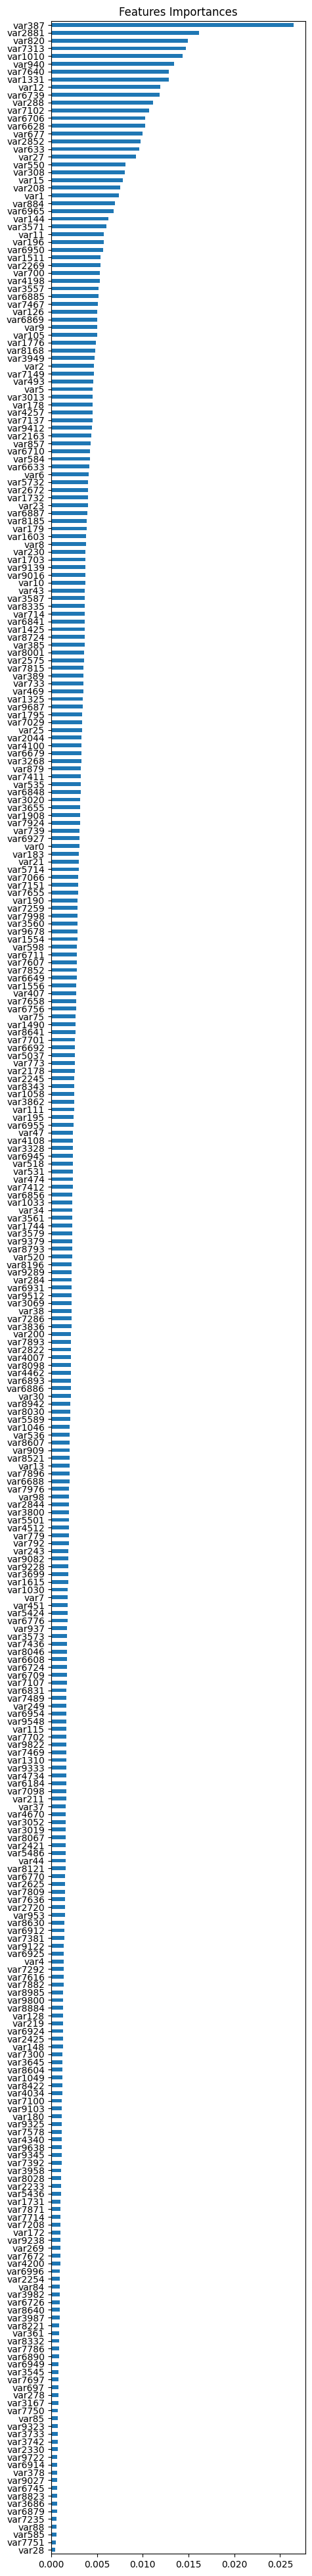

In [ ]:
#illustration des features importances
feature.plotFeatureImportances()
feature.dataFeatureImportances()

In [ ]:
#affichage de leur nombre
len(feature.featureImp)

327

In [ ]:
#Vectorisation des des features importances puis nomalisation
vect = vAssembler(feature.getDF())
vect.vectStringIndex()
vect.vectAssembler()
vect.scalerStandard()

In [ ]:
analyse = dataAnalysis(plt,vect.getDF())


In [ ]:
a=analyse.vizData2D(fn)

<Axes: xlabel='x[0]', ylabel='x[1]'>

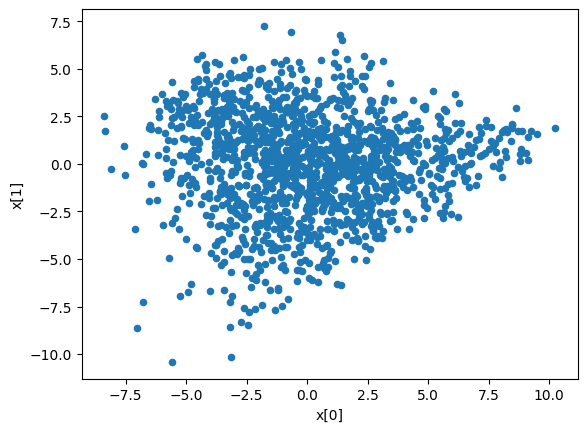

In [ ]:
a.toPandas().plot.scatter('x[0]','x[1]')

In [ ]:
#initialisation des clusters et avec KMeans et evaluation pour déterminer le nombre de classe adéquat
cl = cluster(plt,analyse.getPCA())


In [ ]:
cl.evalClusterPlot(KMeans,10)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

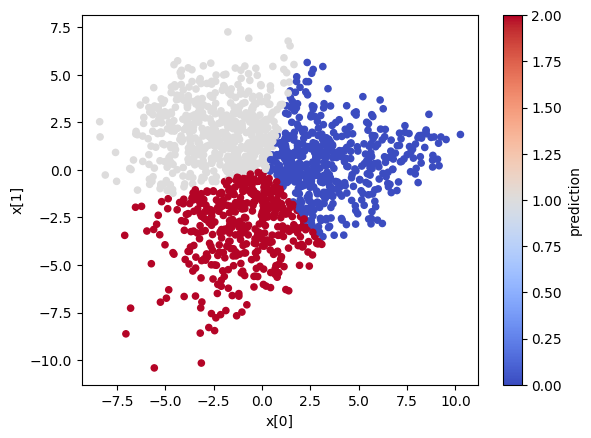

In [ ]:
cl.clusterPlot(KMeans,fn,3)

In [ ]:
#Tableau des groupes déterminés
cl.clusterDF.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  547|
|         2|  439|
|         0|  493|
+----------+-----+



In [ ]:
#On procède de la même manière avec la méthode GaussianMixture

In [ ]:
cl.evalClusterPlot(GaussianMixture,10)

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

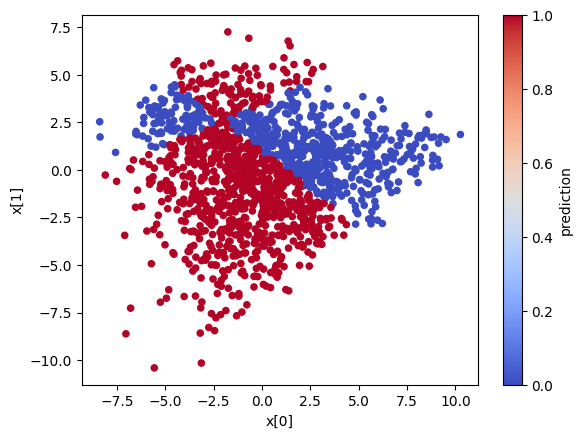

In [ ]:
cl.clusterPlot(GaussianMixture,fn,2)

In [ ]:
cl.clusterDF.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  900|
|         0|  579|
+----------+-----+

